In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import datetime
import random
import pandas as pd
import numpy as np


from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import PIL
from PIL import Image as image

from Dataloader import dataloader, SquarePad


In [2]:
torch.manual_seed(42)
device = (torch.device('cuda') if torch.cuda.is_available()
         else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


### Dataloader

In [3]:
data_path = './trainvalid'

os.getcwd()
image = PIL.Image.open(f"{data_path}/0/0021.jpg")
width, height = image.size
print(width, height)

def load_split_train_vaild(datadir, valid_size = .2):
    train_transforms = transforms.Compose([SquarePad(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(), 
                                       ])
    valid_transforms = transforms.Compose([SquarePad(),
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    valid_data = datasets.ImageFolder(datadir,
                    transform=valid_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=4)
    validloader = torch.utils.data.DataLoader(valid_data,
                   sampler=valid_sampler, batch_size=4)
    

    return trainloader, validloader

2880 2136


torch.Size([3, 224, 224])


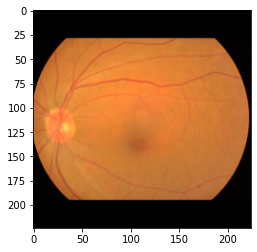

In [4]:
#DataLoad
data_path = './trainvalid/'
trainloader, validloader = load_split_train_vaild(data_path, .2)
print(trainloader.dataset[0][0].size())
plt.imshow(np.uint8(trainloader.dataset[0][0].permute(1,2,0)*255))
plt.show()

In [5]:
trainloader

In [6]:
data_path = './trainvalid'
train_transforms = transforms.Compose([SquarePad(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(), 
                                       ])
train_data = datasets.ImageFolder(data_path,       
                    transform=train_transforms)

In [17]:
train_data[0][1]

0